In [11]:
from pathlib import Path
import geopandas as gpd
import folium 
from shapely.geometry import LineString, Polygon, box, shape
import rasterio
import os
import matplotlib.pyplot as plt
import pandas as pd
import rasterio.features

In [12]:
region = "Noord-Westelijke Delta"

In [13]:
Output_dir = Path(rf"P:\bovenregionale-stresstest-hwn\Analysis\{region}\Outputs")

In [ ]:
'''
root_dir = Path(rf"P:\bovenregionale-stresstest-hwn\Scripts\RA2CE_Model\data\Test_Run")

static_path = root_dir.joinpath("static") #within your root directory there should be a 'static' folder
network_path = static_path.joinpath("network") #within the static folder there should be a 'network' folder
hazard_path = static_path.joinpath("hazard") #within the static folder there should be a 'hazard' folder
output_path = static_path.joinpath("output_graph")
assert root_dir.exists(), "root_dir not found."

'''

In [35]:
hazard_graph = gpd.read_file(Output_dir.joinpath("base_network_hazard.gpkg"), driver='GPKG')

Finding thresholds that are suitable

,fraction_threshold,depth_threshold,flooded_count,isolated_count,score,score_norm,exposure_class
0,0.000000,2.455556,28,6,4.0,1.0,High
1,0.222222,2.455556,28,6,4.0,1.0,High
2,0.555556,2.455556,28,6,4.0,1.0,High
3,0.333333,2.455556,28,6,4.0,1.0,High
4,0.111111,2.455556,28,6,4.0,1.0,High
...,...,...,...,...,...,...,...
95,0.555556,10.000000,0,0,0.0,0.0,Low
96,0.111111,8.922222,0,0,0.0,0.0,Low
97,0.666667,7.844444,0,0,0.0,0.0,Low
98,0.666667,8.922222,0,0,0.0,0.0,Low


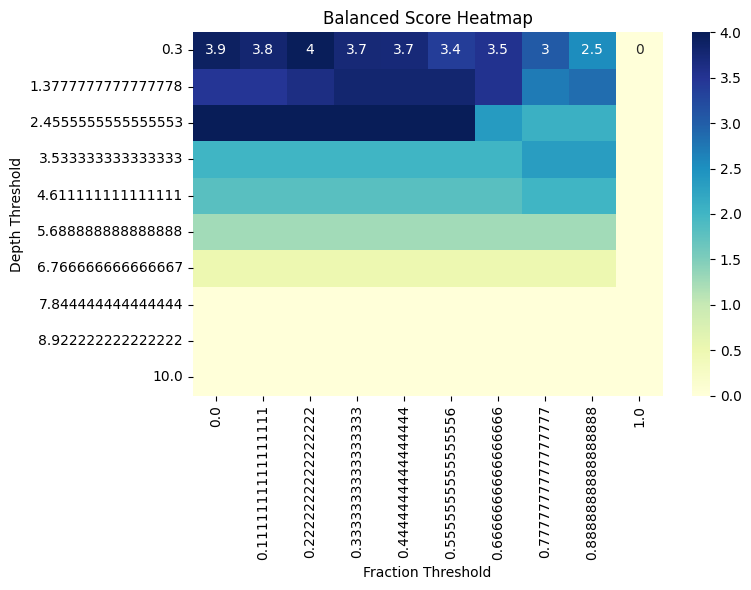

In [43]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # Make sure seaborn is installed

# --- Parameters ---
zone_column = 'zone'  # Optional: column name for spatial aggregation
fraction_range = np.linspace(0, 1, 10)
depth_range = np.linspace(0.3, 10, 10)

# --- Step 1: Load your data ---
gdf_original = hazard_graph.copy()

# --- Step 2: Sensitivity analysis ---
results = []

for f_thresh in fraction_range:
    for d_thresh in depth_range:
        gdf = gdf_original.copy()
        gdf['is_flooded'] = (gdf['EV1_fr'] > f_thresh) & (gdf['EV1_me'] > d_thresh)

        # Identify isolated flooded segments
        def is_isolated(index, flooded_series):
            if not flooded_series.iloc[index]:
                return False
            neighbors = []
            if index > 0:
                neighbors.append(flooded_series.iloc[index - 1])
            if index < len(flooded_series) - 1:
                neighbors.append(flooded_series.iloc[index + 1])
            return not any(neighbors)

        gdf['is_isolated'] = [is_isolated(i, gdf['is_flooded']) for i in range(len(gdf))]

        flooded_count = gdf['is_flooded'].sum()
        isolated_count = gdf['is_isolated'].sum()
        score = flooded_count / (1 + isolated_count)

        results.append({
            'fraction_threshold': f_thresh,
            'depth_threshold': d_thresh,
            'flooded_count': flooded_count,
            'isolated_count': isolated_count,
            'score': score
        })

# --- Step 3: Create DataFrame and classify exposure ---
results_df = pd.DataFrame(results)

# Normalize score for classification
results_df['score_norm'] = (results_df['score'] - results_df['score'].min()) / (results_df['score'].max() - results_df['score'].min())

# Classify exposure levels
def classify_exposure(score):
    if score >= 0.8:
        return 'High'
    elif score >= 0.4:
        return 'Moderate'
    else:
        return 'Low'

results_df['exposure_class'] = results_df['score_norm'].apply(classify_exposure)

# --- Step 4: Display ranked results ---
results_df = results_df.sort_values(by='score', ascending=False).reset_index(drop=True)
display(results_df)

# --- Step 5: Optional heatmap visualization ---
pivot = results_df.pivot(index='depth_threshold', columns='fraction_threshold', values='score')
plt.figure(figsize=(8, 6))
plt.title('Balanced Score Heatmap')
sns.heatmap(pivot, annot=True, cmap='YlGnBu')
plt.xlabel('Fraction Threshold')
plt.ylabel('Depth Threshold')
plt.tight_layout()
plt.show()


In [ ]:

gdf = gdf.set_crs("EPSG:28992", allow_override=True)
gdf.to_file(Output_dir.joinpath("flooded_segments_ver02.gpkg"), driver='GPKG')


AttributeError: 'list' object has no attribute 'set_crs'

In [41]:
#Selected thresholds

# --- Parameters ---
fraction_threshold = 0.5    # Minimum fraction flooded
depth_threshold = 0.5     # Minimum mean depth
zone_column = 'zone'      # Optional: column name for spatial aggregation

Determine for each segment if we should consider it 'flooded' based on a combination of threshold and whether the segment is 'isolated' in its floodedness

In [42]:
# --- Step 1: Load your data ---
gdf = hazard_graph.copy()

# --- Step 2: Filter flooded segments ---
gdf['is_flooded'] = (gdf['EV1_fr'] > fraction_threshold) & (gdf['EV1_me'] > depth_threshold)

# --- Step 3: Identify isolated flooded segments ---
def is_isolated(index, flooded_series):
    if not flooded_series.iloc[index]:
        return False
    neighbors = []
    if index > 0:
        neighbors.append(flooded_series.iloc[index - 1])
    if index < len(flooded_series) - 1:
        neighbors.append(flooded_series.iloc[index + 1])
    return not any(neighbors)

gdf['is_isolated'] = [is_isolated(i, gdf['is_flooded']) for i in range(len(gdf))]

# --- Step 4: Optional aggregation to zones ---
if zone_column in gdf.columns:
    zone_summary = gdf.groupby(zone_column).agg({
        'mean_depth': 'mean',
        'max_depth': 'max',
        'fraction_flooded': 'mean',
        'is_flooded': 'sum',
        'is_isolated': 'sum',
        # Example: keep first value of a non-numeric column
        'some_other_column': 'first'
    }).reset_index()

    # Optional: merge back to original GeoDataFrame
    gdf = gdf.merge(zone_summary, on=zone_column, suffixes=('', '_zone_summary'))

    print("Zone-level summary:")
    print(zone_summary)

In [23]:
print(gdf.columns)

Index(['link_id', 'REF_ID', 'highway', 'avgspeed', 'lanes', 'id_NWB',
       'BST_CODE_N', 'NWSNAAM_HW', 'NETWERKSCH', 'node_A', 'node_B',
       'edge_fid', 'rfid_c', 'rfid', 'length', 'time', 'EV1_mi', 'EV1_ma',
       'EV1_me', 'EV1_fr', 'EV2_mi', 'EV2_ma', 'EV2_me', 'EV2_fr', 'geometry',
       'is_flooded', 'is_isolated'],
      dtype='object')


In [31]:
# Aggregate gdf on NETWERKSCH for EV columns

# Dissolve geometries based on NETWERKSCH
gdf_dissolved = gdf.dissolve(by='NETWERKSCH', as_index=False)

# Aggregate EV columns (mean, max, median)
ev_cols = [col for col in gdf.columns if col.startswith('EV')]
agg_dict = {col: ['mean', 'max', 'median'] for col in ev_cols}
gdf_stats = gdf.groupby('NETWERKSCH').agg(agg_dict)
gdf_stats.columns = [f"{col}_{stat}" for col, stat in gdf_stats.columns]
gdf_stats = gdf_stats.reset_index()

# Merge aggregated stats with dissolved geometries
gdf_agg = gdf_dissolved.merge(gdf_stats, on='NETWERKSCH', how='left')
gdf_agg = gpd.GeoDataFrame(gdf_agg, geometry='geometry', crs=gdf.crs)

# Save to file
gdf_agg = gdf_agg.set_crs("EPSG:28992", allow_override=True)
gdf_agg.to_file(Output_dir.joinpath("Aggregated_flooded_segments.gpkg"), driver='GPKG')

CPLE_AppDefinedError: b'sqlite3_exec(CREATE TABLE gpkg_extensions (table_name TEXT,column_name TEXT,extension_name TEXT NOT NULL,definition TEXT NOT NULL,scope TEXT NOT NULL,CONSTRAINT ge_tce UNIQUE (table_name, column_name, extension_name))) failed: table gpkg_extensions already exists'

Exception ignored in: 'fiona._shim.gdal_flush_cache'
Traceback (most recent call last):
  File "fiona\_err.pyx", line 201, in fiona._err.GDALErrCtxManager.__exit__
fiona._err.CPLE_AppDefinedError: b'sqlite3_exec(CREATE TABLE gpkg_extensions (table_name TEXT,column_name TEXT,extension_name TEXT NOT NULL,definition TEXT NOT NULL,scope TEXT NOT NULL,CONSTRAINT ge_tce UNIQUE (table_name, column_name, extension_name))) failed: table gpkg_extensions already exists'


In [30]:
gdf_agg = gdf_agg.set_crs("EPSG:28992", allow_override=True)
gdf_agg.to_file(Output_dir.joinpath("Aggregated_flooded_segments.gpkg"), driver='GPKG')

CPLE_AppDefinedError: b'sqlite3_exec(CREATE TABLE gpkg_extensions (table_name TEXT,column_name TEXT,extension_name TEXT NOT NULL,definition TEXT NOT NULL,scope TEXT NOT NULL,CONSTRAINT ge_tce UNIQUE (table_name, column_name, extension_name))) failed: table gpkg_extensions already exists'

Exception ignored in: 'fiona._shim.gdal_flush_cache'
Traceback (most recent call last):
  File "fiona\_err.pyx", line 201, in fiona._err.GDALErrCtxManager.__exit__
fiona._err.CPLE_AppDefinedError: b'sqlite3_exec(CREATE TABLE gpkg_extensions (table_name TEXT,column_name TEXT,extension_name TEXT NOT NULL,definition TEXT NOT NULL,scope TEXT NOT NULL,CONSTRAINT ge_tce UNIQUE (table_name, column_name, extension_name))) failed: table gpkg_extensions already exists'
